In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import mrcfile
import torch

from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup
# from cryoS2Sdrop.dataloader import singleCET_dataset, singleCET_FourierDataset

import tomopy.sim.project as proj
from tomopy.recon.algorithm import recon
import matplotlib.pyplot as plt

PARENT_PATH = setup.PARENT_PATH

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80

def standardize(X):
    mean = X.mean()
    std = X.std()
    new_X = (X - mean) / std

    return new_X

def clip(X, low=0.005, high=0.995):
    # works with tensors =)
    return np.clip(X, np.quantile(X, low), np.quantile(X, high))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_dummy.mrc')
# cet_path = os.path.join(PARENT_PATH,
#                         '/home/ubuntu/Thesis/data/S2SDenoising/dummy_tomograms/tomoPhantom_model16_Poisson5000+Gauss5+stripes.mrc')
# cet_path = os.path.join(PARENT_PATH,
#                         '/home/ubuntu/Thesis/data/S2SDenoising/dummy_tomograms/tomoPhantom_model9_Poisson5000+Gauss5.mrc')
tomo_data = read_array(cet_path)
tomo_data = standardize(clip(tomo_data))
tomo_shape = np.array(tomo_data.shape)
tomo_shape

array([232, 464, 464])

In [13]:
fft_data = np.fft.fftshift(np.fft.fftn(tomo_data))
logPower_Fdata = np.log(np.abs(fft_data)**2)
logPower_Fdata = standardize(clip(logPower_Fdata))

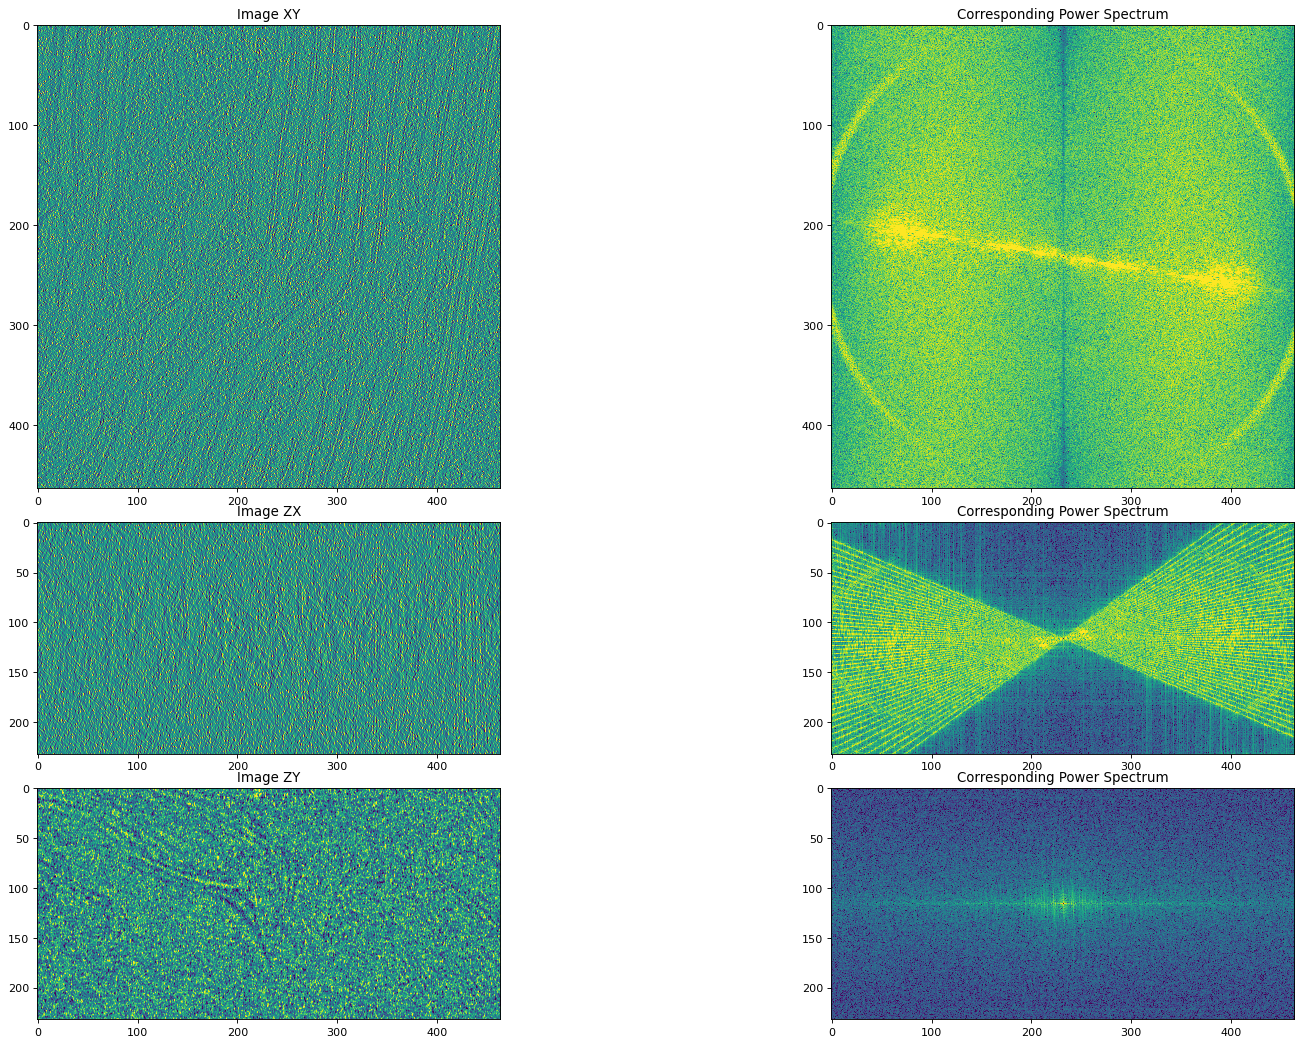

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(20, 13), gridspec_kw={'height_ratios': [2, 1, 1]})  
plt.tight_layout()

ax[0][0].imshow(tomo_data[tomo_shape[0]//2])
ax[0][0].set_title('Image XY')

ax[0][1].imshow(logPower_Fdata[tomo_shape[0]//2])
ax[0][1].set_title('Corresponding Power Spectrum')

ax[1][0].imshow(tomo_data[:, tomo_shape[1]//2, :])
ax[1][0].set_title('Image ZX')

ax[1][1].imshow(logPower_Fdata[:, tomo_shape[1]//2, :])
ax[1][1].set_title('Corresponding Power Spectrum')

ax[2][0].imshow(tomo_data[:, :, tomo_shape[2]//2])
ax[2][0].set_title('Image ZY')

ax[2][1].imshow(logPower_Fdata[:, :, tomo_shape[2]//2])
ax[2][1].set_title('Corresponding Power Spectrum')


plt.show()

(array([22275743.,  7634187.,  7076846.,  4894868.,  3058464.,  1976816.,
         1283924.,   789346.,   460058.,   498420.]),
 array([-1.0074225 , -0.52069729, -0.03397207,  0.45275314,  0.93947835,
         1.42620356,  1.91292877,  2.39965398,  2.88637919,  3.37310441,
         3.85982962]),
 <BarContainer object of 10 artists>)

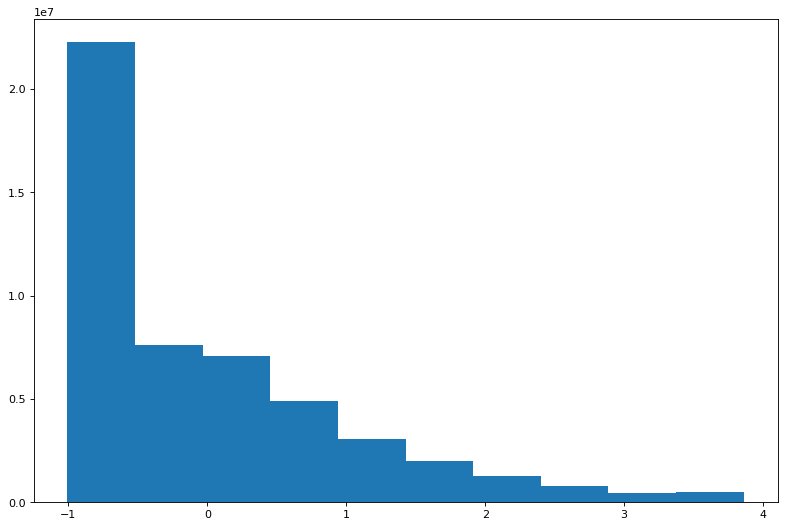

In [15]:
power_Fdata = np.exp(logPower_Fdata)
power_Fdata = standardize(clip(power_Fdata))
plt.hist(power_Fdata.flatten())

In [20]:
mask = (power_Fdata>np.quantile(power_Fdata, 0.1)).astype(int)
logPower_filtered = mask*logPower_Fdata

fft_filtered = mask*fft_data
tomo_filtered = np.fft.ifftn(np.fft.ifftshift(fft_filtered))
tomo_filtered = np.real(tomo_filtered)

(array([ 879422., 2058822., 5416351., 8236705., 5916229., 4786203.,
        7239670., 7799554., 5211628., 2404088.]),
 array([-2.35944979, -1.92549619, -1.49154259, -1.057589  , -0.6236354 ,
        -0.1896818 ,  0.24427179,  0.67822539,  1.11217899,  1.54613258,
         1.98008618]),
 <BarContainer object of 10 artists>)

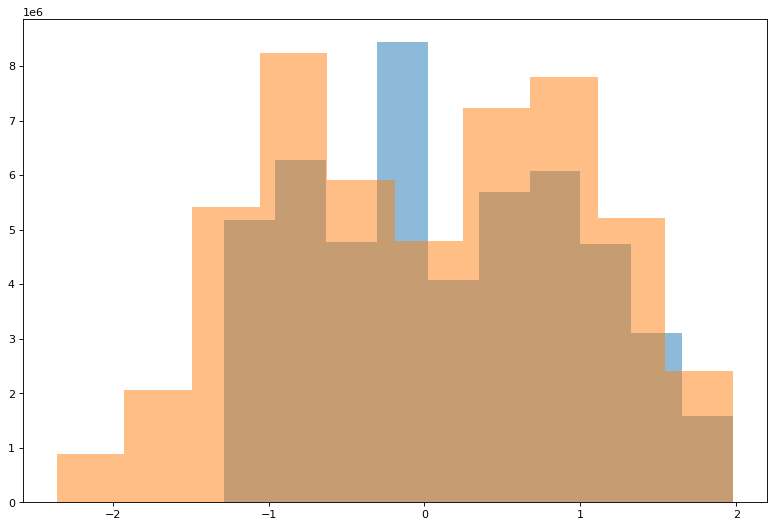

In [21]:
plt.hist(logPower_filtered.flatten(), alpha=0.5)
plt.hist(logPower_Fdata.flatten(), alpha=0.5)

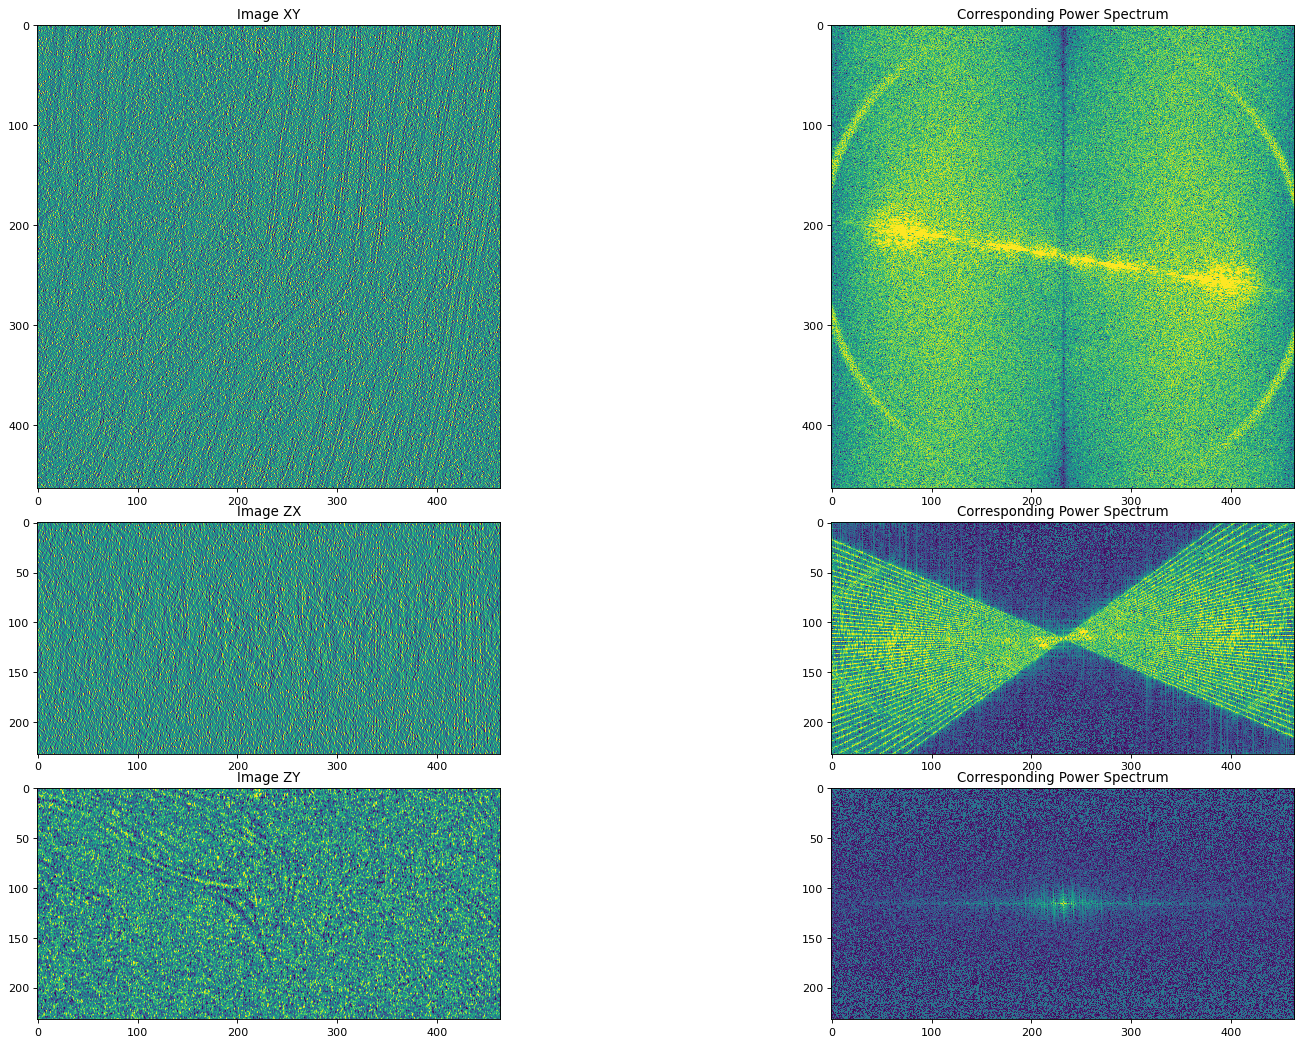

In [22]:
fig, ax = plt.subplots(3, 2, figsize=(20, 13), gridspec_kw={'height_ratios': [2, 1, 1]})  
plt.tight_layout()

ax[0][0].imshow(tomo_filtered[tomo_shape[0]//2])
ax[0][0].set_title('Image XY')

ax[0][1].imshow(logPower_filtered[tomo_shape[0]//2])
ax[0][1].set_title('Corresponding Power Spectrum')

ax[1][0].imshow(tomo_filtered[:, tomo_shape[1]//2, :])
ax[1][0].set_title('Image ZX')

ax[1][1].imshow(logPower_filtered[:, tomo_shape[1]//2, :])
ax[1][1].set_title('Corresponding Power Spectrum')

ax[2][0].imshow(tomo_filtered[:, :, tomo_shape[2]//2])
ax[2][0].set_title('Image ZY')

ax[2][1].imshow(logPower_filtered[:, :, tomo_shape[2]//2])
ax[2][1].set_title('Corresponding Power Spectrum')


plt.show()